# Result_Fig2_2 : Difficulty with Tag Availability

In [1]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

In [2]:
import lib.stats.stats as st
from utils.statistics import *
from lib.distribution_collector import (collect_tag_distributions)
from constants import CONSTANTS
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime

import numpy as np
import pandas as pd
import pickle


In [3]:
path = CONSTANTS.s_tag_result_path
file_list = os.listdir(f'{path}/raw')



In [4]:
df = pd.DataFrame()
for i in file_list:
	with open(f'{path}/raw/{i}', 'rb') as f:
		df = pd.concat([df, pickle.load(f)], axis = 0)


In [5]:
df.shape

(1257012, 6)

In [6]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

In [7]:
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")

In [8]:
df['rel_week'] = np.floor((df['cdate']-std_date).dt.days/7)

In [9]:
df_bf_pro = df[df['rel_week']<0].groupby(['tag']).sum(['pct'])['pct'].sort_values().reset_index()
tagnum = int(np.floor(df_bf_pro.shape[0]*0.2))
bot_tag = list(df_bf_pro.iloc[:tagnum, 0])
top_tag = list(df_bf_pro.iloc[tagnum:, 0])

In [10]:
df_tot = df.groupby(['rel_week']).sum(['pct'])['pct'].reset_index(name = 'tot_pct')
df_pct = pd.merge(df, df_tot, on = 'rel_week')

df_pct['pct_pct'] = df_pct['pct']/df_pct['tot_pct']

df_pct_bot = df_pct[df_pct['tag'].isin(bot_tag)]
df_pct_top = df_pct[df_pct['tag'].isin(top_tag)]

df_pct_top_tot = df_pct_top.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()
df_pct_bot_tot = df_pct_bot.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()


In [11]:
proportion_dict = {'Top 20% Tags' : df_pct_top_tot
                ,   'Bottom 20% Tags' : df_pct_bot_tot}

In [12]:
file_list = os.listdir(f'{path}/agg')
weekly_tag_distributions = []

for file in file_list:          # 파일 개수
    with open(f'{path}/agg/{file}', 'rb') as f:
        part = pickle.load(f)   # part는 list
        weekly_tag_distributions.extend(part)     # 리스트 합치기

In [13]:
weekly_tag_distributions

[{'javascript': 0.040304556990795104,
  'python': 0.05915628117226663,
  'java': 0.020834122504640326,
  'c#': 0.014987941462429133,
  'php': 0.009886738134020228,
  'android': 0.011174665707034357,
  'html': 0.014710153162367262,
  'jquery': 0.004141571019104259,
  'c++': 0.011616601638950971,
  'css': 0.010391807770496357,
  'ios': 0.003548114196244807,
  'sql': 0.010467568215967777,
  'mysql': 0.0061618495650087755,
  'r': 0.01204591082995568,
  'reactjs': 0.01822038713587636,
  'node.js': 0.011061025038827228,
  'arrays': 0.0072098690606967435,
  'c': 0.006982587724282486,
  'asp.net': 0.0017551169867545489,
  'json': 0.005480005555766001,
  'python-3.x': 0.0075507910653181305,
  '.net': 0.002702122555147291,
  'ruby-on-rails': 0.001439448463956968,
  'sql-server': 0.003876409459954291,
  'swift': 0.0039016629417780975,
  'django': 0.005467378814854098,
  'angular': 0.0059850751922421305,
  'objective-c': 0.00036617548644519364,
  'excel': 0.004053183832720937,
  'pandas': 0.011465

In [14]:
ginis = list(map(lambda x: calculate_gini(list(x.values())), weekly_tag_distributions))

In [15]:
entropies = list(map(lambda x: calculate_entropy(list(x.values())), weekly_tag_distributions))

In [16]:
gini_entropy_dict = {'Gini Coefficient' : ginis, 'Entropy' : entropies}

In [17]:
rel_week = np.array(np.arange(-52, 52))

In [18]:
st_0 = st.Stats(rel_week, entropies, 2, 0.95)

In [19]:
F_stat_0, p_value_0 = st_0.chow_test()

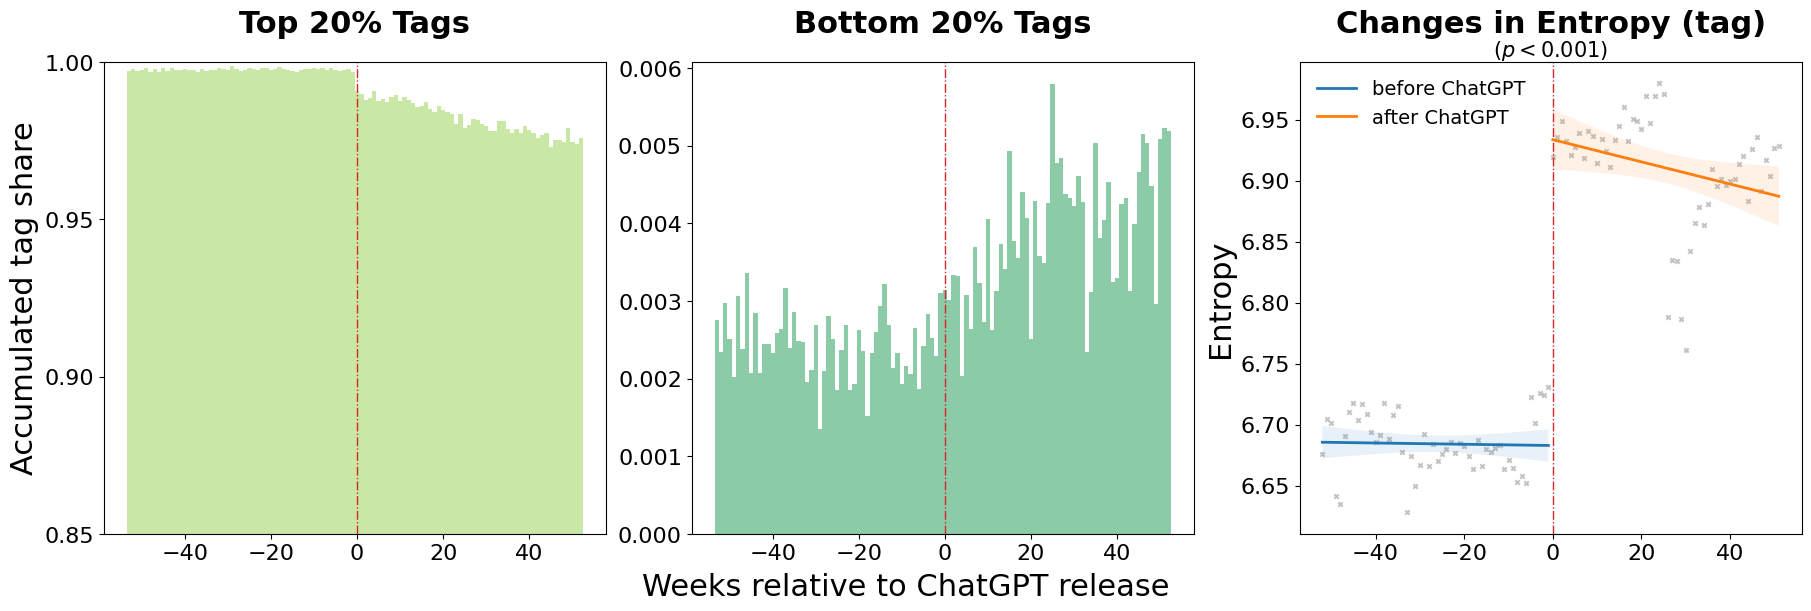

In [20]:
sharey = False 
sharex = True 
g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(1, 3, figsize = (18, 6), constrained_layout=True)
alpha_list = [0.6, 0.5]
color_list = ["#a6d96a", "#1a9850"]

for x, (title, proportion) in enumerate(proportion_dict.items()):
    rel_week = list(proportion['rel_week'])
    values = list(proportion['pct_pct'])
    
    axs[x].bar(rel_week, values, color=color_list[x], width=1.0, align='center', alpha=alpha_list[x]
    )
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)

    if x ==0 :
        axs[x].set_ylim(0.85, 1.0)
        axs[x].set_yticks(np.arange(0.85, 1.01, 0.05))

    # axs[x].set_title(f'{title}', fontsize=25)

    axs[x].text(0.5, 1.05, f"{title}",
            ha='center', va='bottom', fontsize=22, fontweight='bold', transform=axs[x].transAxes)

    axs[x].text(0.5, 1.00, "",
        ha='center', va='bottom', fontsize=15, transform=axs[x].transAxes)  
    axs[x].tick_params(axis='x', labelsize=16)
    axs[x].tick_params(axis='y', labelsize=16)

idx = 2
list_ = gini_entropy_dict['Entropy']
x_rel, divider = get_dist_x_div(list_)

reg_bf = calc_regression_with_ci(x_rel[:divider], list_[:divider])
reg_af = calc_regression_with_ci(x_rel[divider:], list_[divider:])

reg_bf_summary = reg_bf["pred_summary"]
reg_af_summary = reg_af["pred_summary"]

# 회귀선 (예측값)
reg_bf_y_pred = reg_bf_summary["mean"]
reg_af_y_pred = reg_af_summary["mean"]
# 신뢰구간
reg_bf_ci_lower = reg_bf_summary["mean_ci_lower"]
reg_bf_ci_upper = reg_bf_summary["mean_ci_upper"]

reg_af_ci_lower = reg_af_summary["mean_ci_lower"]
reg_af_ci_upper = reg_af_summary["mean_ci_upper"]

p_value_txt = '($p < 0.001$)' if p_value_0 <0.001 else '($p = {p_value_0:.3f}$)'

axs[idx].scatter(x_rel, list_, color = 'darkgray', alpha = 0.7,  s=10, marker='x')
axs[idx].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
# axs[idx].set_ylabel(f"{measure} of Topic Distribution", fontsize = 10)
axs[idx].plot(x_rel[:divider], reg_bf_y_pred, linewidth=2, label = 'before ChatGPT')
axs[idx].plot(x_rel[divider:], reg_af_y_pred, linewidth=2, label = 'after ChatGPT')

axs[idx].fill_between(x_rel[:divider], reg_bf_ci_lower, reg_bf_ci_upper, alpha=0.1)
axs[idx].fill_between(x_rel[divider:], reg_af_ci_lower, reg_af_ci_upper, alpha=0.1)

axs[idx].legend(frameon=False, loc='best', fontsize=14)
# axs[idx].set_title(f"Changes in Entropy (tag)", fontsize=25)
axs[idx].text(0.5, 1.05, f"Changes in Entropy (tag)",
            ha='center', va='bottom', fontsize=22, fontweight='bold', transform=axs[idx].transAxes)

axs[idx].text(0.5, 1.00, f"{p_value_txt}",
        ha='center', va='bottom', fontsize=15, transform=axs[idx].transAxes)  

axs[idx].tick_params(axis='x', labelsize=16)
axs[idx].tick_params(axis='y', labelsize=16)


axs[0].set_ylabel("Accumulated tag share", fontsize = 22)
axs[2].set_ylabel(f"Entropy", fontsize = 22)

fig.supxlabel("Weeks relative to ChatGPT release", fontsize=22) 
plt.savefig(f"./fig/C_Result_Fig2_2.png", dpi=300, bbox_inches='tight')
plt.show();